In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import random
from IPython.core.display import HTML
import shutil
import re

CONV_DROPOUT_P = 0.5
FC_DROPOUT_P = 0.5
OBJECTIVE_NAME = 'voice_cmd'

def make_identifier_regex(name):
    return f"(?P<{name}>[a-zA-Z0-9\-\_]+)"


def make_number_regex(name):
    return f"(?P<{name}>[0-9\.]+)"



RESULT_FILE_REGEX = re.compile(
    f"{make_identifier_regex('model_name')}__c_dropout_p_{CONV_DROPOUT_P}__f_dropout_p_{FC_DROPOUT_P}__feature_{make_identifier_regex('feature_name')}__fold_id_{make_number_regex('fold_id')}__obj_{OBJECTIVE_NAME}"
)

model_names = [
    "VAASRCNN1",
    "VAASRCNN2",
    "VAASRCNN3",
]


DATA_DIR = "results_102/"


random.seed(42)
# COLORS = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
COLORS = ["#7f7f7f", "#1f77b4"]

n = 0
n_train = int(np.ceil(n * .6))
n_test = n - n_train


In [2]:
data_frames = {}

variable_names = []

for result_path in Path(DATA_DIR).iterdir():
    
    match = RESULT_FILE_REGEX.match(result_path.stem)
    if not match:
        print(f"ignoring result file: {result_path}")
        continue
    
    trial_params = match.groupdict()
    
    model_name = trial_params['model_name']
    feature_name = trial_params['feature_name']
    fold_id = int(trial_params['fold_id'])
    
        
    fold_names = []
    
    if not model_name in data_frames:
        data_frames[model_name] = {}
        
    
    fold_name = f"{feature_name}_{fold_id}"
    data_frames[model_name][fold_name] = pd.read_csv(result_path)
    variable_names.extend(list(data_frames[model_name][fold_name].columns))
    
    
    
    #for p in Path(model_path).iterdir():
    #    if not p.suffixes or p.suffixes[-1] != '.csv':
    #        continue
    #    fold_name = p.stem
    #    fold_names.append(fold_name)
    #    data_frames[model_name][fold_name] = pd.read_csv(p)
    #    variable_names.extend(list(data_frames[model_name][p.stem].columns))
    #for fold_name in sorted(fold_names):
    #    print(f"\t{fold_name}")

print(f"VARIABLES")        
for variable_name in sorted(set(variable_names)):
    print(f"\t{variable_name}")
    
for m in data_frames.keys():
    print(f"Model: {m}")
    for f in sorted(data_frames[m].keys()):
        print(f"\tfold: {f}")
        
    

ignoring result file: results_102/train_va_asr_2020-08-28T20:22:18.165669_pid_11730.log
ignoring result file: results_102/plot.gnuplot
ignoring result file: results_102/train_va_asr_2020-08-29T13:18:40.296886_pid_24570.log
ignoring result file: results_102/train_va_asr_2020-08-29T13:18:04.865179_pid_24482.log
ignoring result file: results_102/train_va_asr_2020-08-28T20:22:25.657639_pid_11823.log
VARIABLES
	epoch
	test_acc
	test_acc_device_id__d001
	test_acc_device_id__d002
	test_acc_device_id__d003
	test_acc_language___language_independent
	test_acc_language__francais
	test_acc_language__maninka
	test_acc_language__pular
	test_acc_language__susu
	test_acc_lng
	test_acc_lng_device_id__d001
	test_acc_lng_device_id__d002
	test_acc_lng_device_id__d003
	test_acc_lng_language___language_independent
	test_acc_lng_language__francais
	test_acc_lng_language__maninka
	test_acc_lng_language__pular
	test_acc_lng_language__susu
	test_acc_lng_speaker_gender__F
	test_acc_lng_speaker_gender__M
	test_ac

In [3]:
def get_variable_stats_delete_me(model_name, feature_prefix, variable, sample_size):
    selected_dfs = [v for k, v in data_frames[model_name].items() if k.startswith(feature_prefix)]
    
    epoch_count = selected_dfs[0].shape[0]
    experiment_count = len(selected_dfs)
    
    data = np.zeros((epoch_count, experiment_count))
    
    for index, df in enumerate(selected_dfs):
        data[:, index] = df[variable]
    
    m = np.mean(data, axis=1)
    minimum = np.min(data, axis=1)
    maximum = np.max(data, axis=1)
    
    
    
    sem = np.std(data, axis=1) / np.sqrt(sample_size)
    
    if variable == 'test_acc':
        print(f"{model_name}, {feature_prefix} {variable}, max-mean: {np.max(m)}, max-max: {np.max(maximum)}")
        # print(f"{model_name}, {feature_prefix} {variable}, max: {np.max(m_max)}, min {np.min(m_min)}")
        max_per_fold = np.max(data, axis=(0))
        print(np.mean(max_per_fold))
        
    return data, m, sem, minimum, maximum, sample_size
    
        

In [4]:
def get_best_epochs_per_fold(model_name, feature_prefix, best_epoch_selection_variable='test_acc'):
    selected_dfs = [v for k, v in data_frames[model_name].items() if k.startswith(feature_prefix)]
    epoch_count = selected_dfs[0].shape[0]
    experiment_count = len(selected_dfs)
    
    best_epoch_selection_data = np.zeros((epoch_count, experiment_count))
    for index, df in enumerate(selected_dfs):
        best_epoch_selection_data[:, index] = df[best_epoch_selection_variable]
    ep_best = np.argmax(best_epoch_selection_data, axis=0)
    
    return ep_best

def get_variable_stats(model_name, feature_prefix, variable, best_epoch_selection_variable='test_acc'):
    selected_dfs = [v for k, v in data_frames[model_name].items() if k.startswith(feature_prefix)]
    sample_size = len(selected_dfs)
    print(f"fold count: {sample_size}")
    
    epoch_count = selected_dfs[0].shape[0]
    experiment_count = len(selected_dfs)
    
    data = np.zeros((epoch_count, experiment_count))
    #best_epoch_selection_data = np.zeros((epoch_count, experiment_count))
    
    for index, df in enumerate(selected_dfs):
        data[:, index] = df[variable]
        #best_epoch_selection_data[:, index] = df[best_epoch_selection_variable]
    
    #
    # Stats of the variable @best epoch for each fold
    #
    #ep_best = np.argmax(best_epoch_selection_data, axis=0)
    ep_best = get_best_epochs_per_fold(model_name, feature_prefix, best_epoch_selection_variable)
    
    # value of the variable for the best epoch of each fold
    ep_best_values = [data[ep_best[fold_ix], fold_ix] for fold_ix in range(len(ep_best))]
    ep_best_mean = np.mean(ep_best_values)
    ep_best_sem = np.std(ep_best_values) / np.sqrt(sample_size)
    ep_best_min = np.min(ep_best_values)
    ep_best_max = np.max(ep_best_values)
    
    
    #
    # Stats of the variable @each epoch
    #
    mean = np.mean(data, axis=1)
    minimum = np.min(data, axis=1)
    maximum = np.max(data, axis=1)
    sem = np.std(data, axis=1) / np.sqrt(sample_size)
    
    stats = {
        'data': data,
        'epochs_mean': mean,
        'epochs_sem': sem,
        'epochs_min': minimum,
        'epochs_max': maximum,
        
        'best_epoch_mean': ep_best_mean,
        'best_epoch_sem': ep_best_sem,
        'best_epoch_min': ep_best_min,
        'best_epoch_max': ep_best_max,
        
        'fold_count': sample_size
    }
    
    #if variable == 'test_acc':
    #    print(f"{model_name}, {feature_prefix} {variable}")
    #    [print(f"max {k}", np.max(v)) for k,v in stats.items() if k != 'data']
        
    return stats

In [5]:
def plot_comparative_variables(ax, model_name, feature_prefixes, variable):
    line_styles = ['-', '-']
    for index, feature_prefix in enumerate(feature_prefixes):
        stats = get_variable_stats(model_name, feature_prefix, variable)
        
        x = range(1, stats['data'].shape[0]+1)

        ax.plot(x, stats['epochs_mean'], color=COLORS[index], linestyle=line_styles[index], label=f'{model_name} {feature_prefix}', alpha=1)
        
        ax.fill_between(
            x, 
            stats['epochs_mean'] + stats['epochs_sem'], 
            stats['epochs_mean'] - stats['epochs_sem'], 
            color=COLORS[index], alpha=0.6
        )
        
        ax.fill_between(
            x, 
            stats['epochs_min'], 
            stats['epochs_max'], 
            color=COLORS[index], alpha=0.1
        )

    ax.grid(True)
    ax.title.set_text(variable)
    ax.legend()

In [6]:
def plot_results(model_names, plotted_variables, compared_features):

    plot_width = len(model_names)*10
    plot_height = len(plotted_variables)*10
    fig, axes = plt.subplots(len(plotted_variables), len(model_names), sharex=True, sharey='row', figsize=(plot_width, plot_height))
    axes = axes.reshape(len(plotted_variables), len(model_names))
    for variable_index, variable in enumerate(plotted_variables):
        # fig, axes = plt.subplots(1, len(model_names), sharex=True, sharey=True, figsize=(20, 7))
        for model_index, model_name in enumerate(model_names):
            plot_comparative_variables(
                axes[variable_index, model_index], # axes[variable_index]
                model_name,
                compared_features,
                variable
            )

In [7]:
plotted_variables = [
    'train_loss',
    'test_loss',
    'train_acc',
    'test_acc',
    'train_acc_lng',
    
    'test_acc_language___language_independent',
    'test_acc_language__francais',
    'test_acc_language__maninka',
    'test_acc_language__pular',
    'test_acc_language__susu',
    
    
    'test_acc_speaker_gender__F',
    'test_acc_speaker_gender__M',
    'test_acc_speaker_mothertongue__maninka',
    'test_acc_speaker_mothertongue__pular',
    'test_acc_speaker_mothertongue__susu',
    
    'test_acc_device_id__d001',
    'test_acc_device_id__d002',
    'test_acc_device_id__d003',

]


additional_plotted_summary_variables = [
    'test_acc_language___language_independent',
    'test_acc_language__francais',
    'test_acc_language__maninka',
    'test_acc_language__pular',
    'test_acc_language__susu',
    'spacer',
    'test_acc_speaker_gender__F',
    'test_acc_speaker_gender__M',
    'spacer',
    'test_acc_speaker_mothertongue__maninka',
    'test_acc_speaker_mothertongue__pular',
    'test_acc_speaker_mothertongue__susu',
    'spacer',
    'test_acc_device_id__d001',
    'test_acc_device_id__d002',
    'test_acc_device_id__d003',
]

# Language classification with context features

In [8]:
#compared_features = ['wav2vec_features-c', 'retrained-wav2vec_features-c']
#plot_results(model_names, plotted_variables, compared_features)

In [9]:
data_frames[model_name].keys()

dict_keys(['retrained-wav2vec_features-c_2', 'wav2vec_features-c_2', 'wav2vec_features-c_0', 'wav2vec_features-z_3', 'retrained-wav2vec_features-z_2', 'retrained-wav2vec_features-c_1', 'retrained-wav2vec_features-c_3', 'retrained-wav2vec_features-z_4', 'wav2vec_features-z_0', 'retrained-wav2vec_features-z_0', 'wav2vec_features-z_4', 'wav2vec_features-z_2', 'retrained-wav2vec_features-c_0', 'wav2vec_features-c_3', 'retrained-wav2vec_features-z_1', 'wav2vec_features-z_1', 'wav2vec_features-c_4', 'wav2vec_features-c_1', 'retrained-wav2vec_features-c_4', 'retrained-wav2vec_features-z_3'])

# Language Classification With Latent Features

fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 2
fold count: 1
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 2
fold count: 1
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 2
fold count: 1
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 2
fold count: 1
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 2
fold count: 1
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 2
fold count: 1
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 2
fold count: 1
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 2
fold count: 1
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 2
fold count: 1
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 2
fold count: 1
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 2
fold count: 1
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 2
fold c

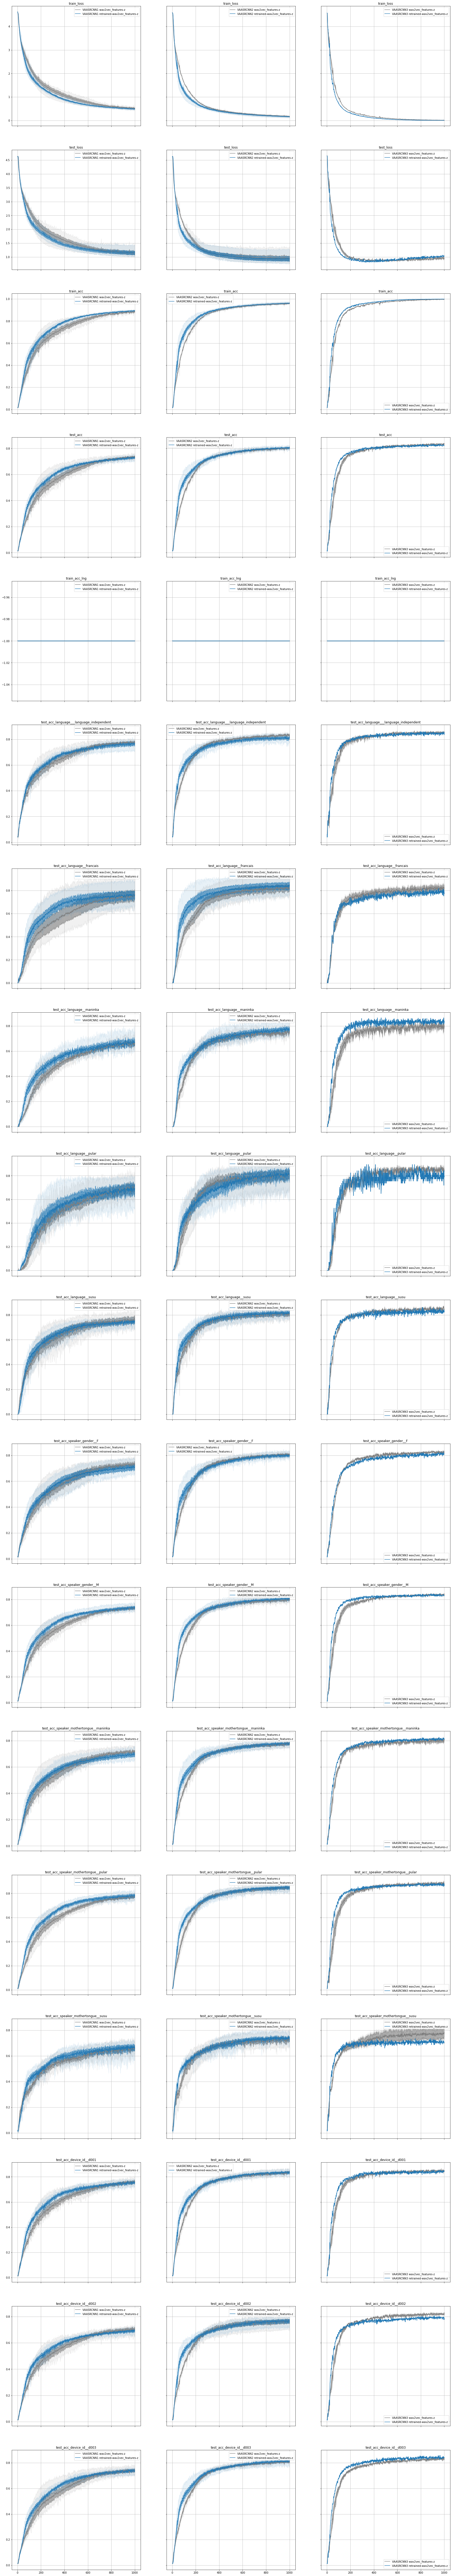

In [10]:
compared_features = ['wav2vec_features-z', 'retrained-wav2vec_features-z']
plot_results(model_names, plotted_variables, compared_features)

# Best epoch summaries

In [11]:
def make_label_str(model_name, feature_name):
    m_name = model_name.replace('LangId','')# .replace("1", "")

    f_name = feature_name.replace(
        "retrained-wav2vec_features-z", "OUR  Latent"
    ).replace(
        "retrained-wav2vec_features-c", "OUR  Context"
    ).replace(
        "wav2vec_features-z", "BSLN  Latent"
    ).replace(
        "wav2vec_features-c", "BSLN  Context"
    )


    # return m_name, f_name
    return f"{f_name} - {m_name}"

In [12]:
additional_plotted_summary_variables

['test_acc_language___language_independent',
 'test_acc_language__francais',
 'test_acc_language__maninka',
 'test_acc_language__pular',
 'test_acc_language__susu',
 'spacer',
 'test_acc_speaker_gender__F',
 'test_acc_speaker_gender__M',
 'spacer',
 'test_acc_speaker_mothertongue__maninka',
 'test_acc_speaker_mothertongue__pular',
 'test_acc_speaker_mothertongue__susu',
 'spacer',
 'test_acc_device_id__d001',
 'test_acc_device_id__d002',
 'test_acc_device_id__d003']

In [30]:
def plot_summary_results(model_names, plotted_variables, compared_features):
    
    count_variables = [v.replace("test_acc_", "test_n_") for v in plotted_variables if v != "spacer"]
    requested_variables = list((set(plotted_variables + count_variables)))
    
    series_means = {v:[] for v in requested_variables}
    series_sems = {v:[] for v in requested_variables}
    series_mins = {v:[] for v in requested_variables}
    series_maxes = {v:[] for v in requested_variables}
    
    series_labels = {v:[] for v in requested_variables}
    fold_counts = []
    
    
    
    
    for variable in requested_variables:
        for feature_prefix in compared_features:
            
            for model_name in model_names:
                stats = get_variable_stats(model_name, feature_prefix, variable)
                series_means[variable].append(stats['best_epoch_mean'])
                series_sems[variable].append(stats['best_epoch_sem'])
                series_mins[variable].append(stats['best_epoch_min'])
                series_maxes[variable].append(stats['best_epoch_max'])
                series_labels[variable].append((model_name, feature_prefix))
                fold_counts.append(stats['fold_count'])
    
    # assert len(set(fold_counts)) == 1,  f"Inconsistent number of folds for model_names: {model_names}, features: {compared_features}: {fold_counts}"
    
    
    fold_count = fold_counts[0]
    
    for v in plotted_variables:
        df = pd.DataFrame(
            data={
                f'{v}_labels': [make_label_str(l[0], l[1]) for l in series_labels[v]],
                f'{v}_means': series_means[v],
                f'{v}_sems': series_sems[v],
            }
        )
        display(df)
    
    # Variables
    # 'train_loss', 'test_loss', 
    # 'train_acc', 'test_acc', 
    # 'test_acc_gender_male', 'test_acc_gender_female', 
    # 'test_acc_language_maninka', 'test_acc_language_pular', 'test_acc_language_susu'
    
    fig, ax = plt.subplots(figsize=(15, 10))
    #plt.bar(labels, mean_train_acc)
    #print(labels)
    bar_width = 5
    bar_margin = 20
    
    label_count = len(series_labels['test_acc'])
    
    colors = {
        "male": "#58508d",
        "female": "#ff6361",
        "maninka": "#88290d",
        "susu": "#b44f0f",
        "pular": "#dc790b",
        "train": "#7f7f7f",
        "test":"#4682b4"
    }

    
    #('test_acc_speaker_count_multiple', fold_count),
    #('test_acc_speaker_count_single', fold_count),
    
    
    #('test_acc_utterance_multilingual', fold_count),
    #('test_acc_utterance_verbal_nod', fold_count),
    
    
    #('test_acc_channel_music', fold_count),
    #('test_acc_channel_noise', fold_count),
    #('test_acc_channel_telephone', fold_count)
    

    train_y_pos = (bar_width+bar_margin)*np.arange(label_count)
    test_y_pos =(bar_width+bar_margin)*np.arange(label_count)
    y_bias = {}
    
    y_pos = 3
    for bias_variable in additional_plotted_summary_variables:
        if bias_variable == 'spacer':
            y_pos += .5
        else:
            y_pos += 1.1
            y_bias[bias_variable] = (bar_width+bar_margin)*np.arange(label_count) + y_pos

    ax.barh(train_y_pos, series_means['train_acc'], height=5, xerr=series_sems['train_acc'], color=colors['train'])
    ax.barh(test_y_pos, series_means['test_acc'], height=5, xerr=series_sems['test_acc'], color=colors['test']) # color=COLORS[2]
    
    bias_alpha = 0.6
    for bias_variable in additional_plotted_summary_variables:
        if bias_variable != 'spacer':
            ax.barh(y_bias[bias_variable], series_means[bias_variable], height=1, xerr=series_sems[bias_variable], color=colors['male'], alpha=bias_alpha)
        
        
    for i, label in enumerate(series_labels['test_acc']):
        (model_name, feature_name) = label

        
        
        label_str = make_label_str(model_name, feature_name)

        train_acc_label_str = f"{series_means['train_acc'][i]:.02%}"
        test_acc_label_str = f"{series_means['test_acc'][i]:.02%}"

        ax.text(0.01, train_y_pos[i], label_str, color='white', fontsize="x-large", fontweight="bold")

        ax.text(series_means['train_acc'][i]-0.07, train_y_pos[i]-0.7, train_acc_label_str, color='white', fontsize="large")
        ax.text(series_means['test_acc'][i]-0.07, train_y_pos[i]-0.7, test_acc_label_str, color='white', fontsize="large")
        

        for bias_variable in additional_plotted_summary_variables:
            if bias_variable != 'spacer':
                ax.barh(y_bias[bias_variable], series_means[bias_variable], height=1, xerr=series_sems[bias_variable], color=colors['male'], alpha=bias_alpha)
                bias_count_variable = bias_variable.replace("test_acc_", "test_n_")
                ax.text(0.01, y_bias[bias_variable][i]-0.3, f"{bias_variable} ({series_means[bias_count_variable][i]})", color='black', fontsize="small")

        
        ax.legend(["TRAIN", "TEST"])
        ax.set_xlim(0, 1)
        ax.get_yaxis().set_ticks([])
        ax.set_title(f"Average and SEM (n={fold_count} folds) Speech Recognition Accuracies. Conv Dropout p={CONV_DROPOUT_P}. FC Dropout p={FC_DROPOUT_P}")
        ax.grid(True)

        

fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5


train_loss_labels  train_loss_means  train_loss_sems
0  BSLN  Latent - VAASRCNN1          0.523010         0.024111
1   OUR  Latent - VAASRCNN1          0.491868         0.018619

test_loss_labels  test_loss_means  test_loss_sems
0  BSLN  Latent - VAASRCNN1         1.130674        0.062900
1   OUR  Latent - VAASRCNN1         1.131138        0.067369

train_acc_labels  train_acc_means  train_acc_sems
0  BSLN  Latent - VAASRCNN1         0.886640        0.004841
1   OUR  Latent - VAASRCNN1         0.894627        0.003388

test_acc_labels  test_acc_means  test_acc_sems
0  BSLN  Latent - VAASRCNN1        0.747815       0.005578
1   OUR  Latent - VAASRCNN1        0.740279       0.006911

train_acc_lng_labels  train_acc_lng_means  train_acc_lng_sems
0  BSLN  Latent - VAASRCNN1                 -1.0                 0.0
1   OUR  Latent - VAASRCNN1                 -1.0                 0.0

test_acc_language___language_independent_labels  \
0                        BSLN  Latent - VAASRCNN1   
1                         OUR  Latent - VAASRCNN1   

   test_acc_language___language_independent_means  \
0                                        0.788909   
1                                        0.771535   

   test_acc_language___language_independent_sems  
0                                       0.005136  
1                                       0.015126

test_acc_language__francais_labels  test_acc_language__francais_means  \
0           BSLN  Latent - VAASRCNN1                           0.775606   
1            OUR  Latent - VAASRCNN1                           0.760466   

   test_acc_language__francais_sems  
0                          0.040584  
1                          0.030902

test_acc_language__maninka_labels  test_acc_language__maninka_means  \
0          BSLN  Latent - VAASRCNN1                          0.671987   
1           OUR  Latent - VAASRCNN1                          0.687233   

   test_acc_language__maninka_sems  
0                         0.017132  
1                         0.020673

test_acc_language__pular_labels  test_acc_language__pular_means  \
0        BSLN  Latent - VAASRCNN1                        0.697980   
1         OUR  Latent - VAASRCNN1                        0.707218   

   test_acc_language__pular_sems  
0                       0.037456  
1                       0.034383

test_acc_language__susu_labels  test_acc_language__susu_means  \
0       BSLN  Latent - VAASRCNN1                       0.779847   
1        OUR  Latent - VAASRCNN1                       0.756033   

   test_acc_language__susu_sems  
0                      0.021943  
1                      0.010288

test_acc_speaker_gender__F_labels  test_acc_speaker_gender__F_means  \
0          BSLN  Latent - VAASRCNN1                          0.751009   
1           OUR  Latent - VAASRCNN1                          0.720682   

   test_acc_speaker_gender__F_sems  
0                         0.016822  
1                         0.018603

test_acc_speaker_gender__M_labels  test_acc_speaker_gender__M_means  \
0          BSLN  Latent - VAASRCNN1                          0.744073   
1           OUR  Latent - VAASRCNN1                          0.746875   

   test_acc_speaker_gender__M_sems  
0                         0.006723  
1                         0.010492

test_acc_speaker_mothertongue__maninka_labels  \
0                      BSLN  Latent - VAASRCNN1   
1                       OUR  Latent - VAASRCNN1   

   test_acc_speaker_mothertongue__maninka_means  \
0                                      0.732039   
1                                      0.707344   

   test_acc_speaker_mothertongue__maninka_sems  
0                                     0.009592  
1                                     0.015174

test_acc_speaker_mothertongue__pular_labels  \
0                    BSLN  Latent - VAASRCNN1   
1                     OUR  Latent - VAASRCNN1   

   test_acc_speaker_mothertongue__pular_means  \
0                                    0.784645   
1                                    0.785895   

   test_acc_speaker_mothertongue__pular_sems  
0                                   0.010167  
1                                   0.014927

test_acc_speaker_mothertongue__susu_labels  \
0                   BSLN  Latent - VAASRCNN1   
1                    OUR  Latent - VAASRCNN1   

   test_acc_speaker_mothertongue__susu_means  \
0                                   0.666613   
1                                   0.686363   

   test_acc_speaker_mothertongue__susu_sems  
0                                  0.013750  
1                                  0.015039

test_acc_device_id__d001_labels  test_acc_device_id__d001_means  \
0        BSLN  Latent - VAASRCNN1                        0.775255   
1         OUR  Latent - VAASRCNN1                        0.767830   

   test_acc_device_id__d001_sems  
0                       0.010709  
1                       0.008303

test_acc_device_id__d002_labels  test_acc_device_id__d002_means  \
0        BSLN  Latent - VAASRCNN1                        0.715674   
1         OUR  Latent - VAASRCNN1                        0.702813   

   test_acc_device_id__d002_sems  
0                       0.011278  
1                       0.008683

test_acc_device_id__d003_labels  test_acc_device_id__d003_means  \
0        BSLN  Latent - VAASRCNN1                        0.752516   
1         OUR  Latent - VAASRCNN1                        0.750195   

   test_acc_device_id__d003_sems  
0                       0.011497  
1                       0.010038

fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5


train_loss_labels  train_loss_means  train_loss_sems
0  BSLN  Context - VAASRCNN1          0.380543         0.024183
1   OUR  Context - VAASRCNN1          0.512377         0.018840

test_loss_labels  test_loss_means  test_loss_sems
0  BSLN  Context - VAASRCNN1         1.059140        0.083357
1   OUR  Context - VAASRCNN1         1.175203        0.068255

train_acc_labels  train_acc_means  train_acc_sems
0  BSLN  Context - VAASRCNN1         0.917491        0.004710
1   OUR  Context - VAASRCNN1         0.881615        0.005353

test_acc_labels  test_acc_means  test_acc_sems
0  BSLN  Context - VAASRCNN1        0.762781       0.007074
1   OUR  Context - VAASRCNN1        0.718059       0.009436

train_acc_lng_labels  train_acc_lng_means  train_acc_lng_sems
0  BSLN  Context - VAASRCNN1                 -1.0                 0.0
1   OUR  Context - VAASRCNN1                 -1.0                 0.0

test_acc_language___language_independent_labels  \
0                       BSLN  Context - VAASRCNN1   
1                        OUR  Context - VAASRCNN1   

   test_acc_language___language_independent_means  \
0                                        0.784380   
1                                        0.756972   

   test_acc_language___language_independent_sems  
0                                       0.018075  
1                                       0.014820

test_acc_language__francais_labels  test_acc_language__francais_means  \
0          BSLN  Context - VAASRCNN1                           0.781474   
1           OUR  Context - VAASRCNN1                           0.754427   

   test_acc_language__francais_sems  
0                          0.018398  
1                          0.036603

test_acc_language__maninka_labels  test_acc_language__maninka_means  \
0         BSLN  Context - VAASRCNN1                          0.722154   
1          OUR  Context - VAASRCNN1                          0.668249   

   test_acc_language__maninka_sems  
0                         0.013782  
1                         0.021779

test_acc_language__pular_labels  test_acc_language__pular_means  \
0       BSLN  Context - VAASRCNN1                        0.737636   
1        OUR  Context - VAASRCNN1                        0.619517   

   test_acc_language__pular_sems  
0                       0.033681  
1                       0.057698

test_acc_language__susu_labels  test_acc_language__susu_means  \
0      BSLN  Context - VAASRCNN1                       0.779613   
1       OUR  Context - VAASRCNN1                       0.740097   

   test_acc_language__susu_sems  
0                      0.014544  
1                      0.011191

test_acc_speaker_gender__F_labels  test_acc_speaker_gender__F_means  \
0         BSLN  Context - VAASRCNN1                          0.747642   
1          OUR  Context - VAASRCNN1                          0.699144   

   test_acc_speaker_gender__F_sems  
0                         0.016327  
1                         0.009074

test_acc_speaker_gender__M_labels  test_acc_speaker_gender__M_means  \
0         BSLN  Context - VAASRCNN1                          0.768549   
1          OUR  Context - VAASRCNN1                          0.725758   

   test_acc_speaker_gender__M_sems  
0                         0.011920  
1                         0.011862

test_acc_speaker_mothertongue__maninka_labels  \
0                     BSLN  Context - VAASRCNN1   
1                      OUR  Context - VAASRCNN1   

   test_acc_speaker_mothertongue__maninka_means  \
0                                      0.745682   
1                                      0.696623   

   test_acc_speaker_mothertongue__maninka_sems  
0                                     0.008240  
1                                     0.009457

test_acc_speaker_mothertongue__pular_labels  \
0                   BSLN  Context - VAASRCNN1   
1                    OUR  Context - VAASRCNN1   

   test_acc_speaker_mothertongue__pular_means  \
0                                    0.798385   
1                                    0.757348   

   test_acc_speaker_mothertongue__pular_sems  
0                                   0.014138  
1                                   0.013872

test_acc_speaker_mothertongue__susu_labels  \
0                  BSLN  Context - VAASRCNN1   
1                   OUR  Context - VAASRCNN1   

   test_acc_speaker_mothertongue__susu_means  \
0                                   0.698215   
1                                   0.633025   

   test_acc_speaker_mothertongue__susu_sems  
0                                  0.014582  
1                                  0.036344

test_acc_device_id__d001_labels  test_acc_device_id__d001_means  \
0       BSLN  Context - VAASRCNN1                        0.792595   
1        OUR  Context - VAASRCNN1                        0.733538   

   test_acc_device_id__d001_sems  
0                       0.007994  
1                       0.010619

test_acc_device_id__d002_labels  test_acc_device_id__d002_means  \
0       BSLN  Context - VAASRCNN1                        0.728998   
1        OUR  Context - VAASRCNN1                        0.689375   

   test_acc_device_id__d002_sems  
0                       0.015515  
1                       0.014878

test_acc_device_id__d003_labels  test_acc_device_id__d003_means  \
0       BSLN  Context - VAASRCNN1                        0.766748   
1        OUR  Context - VAASRCNN1                        0.731265   

   test_acc_device_id__d003_sems  
0                       0.009158  
1                       0.006601

fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5


train_loss_labels  train_loss_means  train_loss_sems
0  BSLN  Latent - VAASRCNN2          0.183017         0.013754
1   OUR  Latent - VAASRCNN2          0.177541         0.016603

test_loss_labels  test_loss_means  test_loss_sems
0  BSLN  Latent - VAASRCNN2         0.936405        0.089785
1   OUR  Latent - VAASRCNN2         0.912786        0.081624

train_acc_labels  train_acc_means  train_acc_sems
0  BSLN  Latent - VAASRCNN2         0.959346        0.003274
1   OUR  Latent - VAASRCNN2         0.961598        0.003573

test_acc_labels  test_acc_means  test_acc_sems
0  BSLN  Latent - VAASRCNN2        0.811707       0.003962
1   OUR  Latent - VAASRCNN2        0.814318       0.004414

train_acc_lng_labels  train_acc_lng_means  train_acc_lng_sems
0  BSLN  Latent - VAASRCNN2                 -1.0                 0.0
1   OUR  Latent - VAASRCNN2                 -1.0                 0.0

test_acc_language___language_independent_labels  \
0                        BSLN  Latent - VAASRCNN2   
1                         OUR  Latent - VAASRCNN2   

   test_acc_language___language_independent_means  \
0                                        0.843039   
1                                        0.818259   

   test_acc_language___language_independent_sems  
0                                       0.005536  
1                                       0.009122

test_acc_language__francais_labels  test_acc_language__francais_means  \
0           BSLN  Latent - VAASRCNN2                           0.829351   
1            OUR  Latent - VAASRCNN2                           0.851864   

   test_acc_language__francais_sems  
0                          0.025289  
1                          0.029155

test_acc_language__maninka_labels  test_acc_language__maninka_means  \
0          BSLN  Latent - VAASRCNN2                          0.766121   
1           OUR  Latent - VAASRCNN2                          0.773681   

   test_acc_language__maninka_sems  
0                         0.016977  
1                         0.017405

test_acc_language__pular_labels  test_acc_language__pular_means  \
0        BSLN  Latent - VAASRCNN2                        0.817507   
1         OUR  Latent - VAASRCNN2                        0.822264   

   test_acc_language__pular_sems  
0                       0.033835  
1                       0.034566

test_acc_language__susu_labels  test_acc_language__susu_means  \
0       BSLN  Latent - VAASRCNN2                       0.807498   
1        OUR  Latent - VAASRCNN2                       0.824578   

   test_acc_language__susu_sems  
0                      0.013069  
1                      0.008647

test_acc_speaker_gender__F_labels  test_acc_speaker_gender__F_means  \
0          BSLN  Latent - VAASRCNN2                          0.817493   
1           OUR  Latent - VAASRCNN2                          0.807551   

   test_acc_speaker_gender__F_sems  
0                         0.006223  
1                         0.008996

test_acc_speaker_gender__M_labels  test_acc_speaker_gender__M_means  \
0          BSLN  Latent - VAASRCNN2                          0.806260   
1           OUR  Latent - VAASRCNN2                          0.815778   

   test_acc_speaker_gender__M_sems  
0                         0.008049  
1                         0.008442

test_acc_speaker_mothertongue__maninka_labels  \
0                      BSLN  Latent - VAASRCNN2   
1                       OUR  Latent - VAASRCNN2   

   test_acc_speaker_mothertongue__maninka_means  \
0                                      0.785297   
1                                      0.789219   

   test_acc_speaker_mothertongue__maninka_sems  
0                                     0.010473  
1                                     0.009899

test_acc_speaker_mothertongue__pular_labels  \
0                    BSLN  Latent - VAASRCNN2   
1                     OUR  Latent - VAASRCNN2   

   test_acc_speaker_mothertongue__pular_means  \
0                                    0.857659   
1                                    0.854691   

   test_acc_speaker_mothertongue__pular_sems  
0                                   0.009113  
1                                   0.009834

test_acc_speaker_mothertongue__susu_labels  \
0                   BSLN  Latent - VAASRCNN2   
1                    OUR  Latent - VAASRCNN2   

   test_acc_speaker_mothertongue__susu_means  \
0                                   0.733257   
1                                   0.750480   

   test_acc_speaker_mothertongue__susu_sems  
0                                  0.016984  
1                                  0.011621

test_acc_device_id__d001_labels  test_acc_device_id__d001_means  \
0        BSLN  Latent - VAASRCNN2                        0.843889   
1         OUR  Latent - VAASRCNN2                        0.847121   

   test_acc_device_id__d001_sems  
0                       0.005507  
1                       0.007946

test_acc_device_id__d002_labels  test_acc_device_id__d002_means  \
0        BSLN  Latent - VAASRCNN2                        0.773165   
1         OUR  Latent - VAASRCNN2                        0.772501   

   test_acc_device_id__d002_sems  
0                       0.016594  
1                       0.013227

test_acc_device_id__d003_labels  test_acc_device_id__d003_means  \
0        BSLN  Latent - VAASRCNN2                        0.818067   
1         OUR  Latent - VAASRCNN2                        0.823332   

   test_acc_device_id__d003_sems  
0                       0.004386  
1                       0.009384

fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5
fold count: 5


train_loss_labels  train_loss_means  train_loss_sems
0  BSLN  Context - VAASRCNN2          0.117246         0.012738
1   OUR  Context - VAASRCNN2          0.180230         0.015804

test_loss_labels  test_loss_means  test_loss_sems
0  BSLN  Context - VAASRCNN2         0.903622        0.101644
1   OUR  Context - VAASRCNN2         0.992239        0.095054

train_acc_labels  train_acc_means  train_acc_sems
0  BSLN  Context - VAASRCNN2         0.972406        0.002798
1   OUR  Context - VAASRCNN2         0.958852        0.003586

test_acc_labels  test_acc_means  test_acc_sems
0  BSLN  Context - VAASRCNN2        0.828138       0.004447
1   OUR  Context - VAASRCNN2        0.792401       0.006138

train_acc_lng_labels  train_acc_lng_means  train_acc_lng_sems
0  BSLN  Context - VAASRCNN2                 -1.0                 0.0
1   OUR  Context - VAASRCNN2                 -1.0                 0.0

test_acc_language___language_independent_labels  \
0                       BSLN  Context - VAASRCNN2   
1                        OUR  Context - VAASRCNN2   

   test_acc_language___language_independent_means  \
0                                        0.843539   
1                                        0.809063   

   test_acc_language___language_independent_sems  
0                                       0.008647  
1                                       0.010907

test_acc_language__francais_labels  test_acc_language__francais_means  \
0          BSLN  Context - VAASRCNN2                           0.849093   
1           OUR  Context - VAASRCNN2                           0.842391   

   test_acc_language__francais_sems  
0                          0.027440  
1                          0.020009

test_acc_language__maninka_labels  test_acc_language__maninka_means  \
0         BSLN  Context - VAASRCNN2                          0.786757   
1          OUR  Context - VAASRCNN2                          0.755859   

   test_acc_language__maninka_sems  
0                         0.009993  
1                         0.015268

test_acc_language__pular_labels  test_acc_language__pular_means  \
0       BSLN  Context - VAASRCNN2                        0.816994   
1        OUR  Context - VAASRCNN2                        0.765563   

   test_acc_language__pular_sems  
0                       0.024512  
1                       0.035986

test_acc_language__susu_labels  test_acc_language__susu_means  \
0      BSLN  Context - VAASRCNN2                       0.837196   
1       OUR  Context - VAASRCNN2                       0.796397   

   test_acc_language__susu_sems  
0                      0.014558  
1                      0.010676

test_acc_speaker_gender__F_labels  test_acc_speaker_gender__F_means  \
0         BSLN  Context - VAASRCNN2                          0.826830   
1          OUR  Context - VAASRCNN2                          0.775213   

   test_acc_speaker_gender__F_sems  
0                         0.012404  
1                         0.010445

test_acc_speaker_gender__M_labels  test_acc_speaker_gender__M_means  \
0         BSLN  Context - VAASRCNN2                          0.827271   
1          OUR  Context - VAASRCNN2                          0.797919   

   test_acc_speaker_gender__M_sems  
0                         0.012878  
1                         0.011821

test_acc_speaker_mothertongue__maninka_labels  \
0                     BSLN  Context - VAASRCNN2   
1                      OUR  Context - VAASRCNN2   

   test_acc_speaker_mothertongue__maninka_means  \
0                                      0.805986   
1                                      0.770773   

   test_acc_speaker_mothertongue__maninka_sems  
0                                     0.006960  
1                                     0.008698

test_acc_speaker_mothertongue__pular_labels  \
0                   BSLN  Context - VAASRCNN2   
1                    OUR  Context - VAASRCNN2   

   test_acc_speaker_mothertongue__pular_means  \
0                                    0.861829   
1                                    0.831786   

   test_acc_speaker_mothertongue__pular_sems  
0                                   0.009840  
1                                   0.011994

test_acc_speaker_mothertongue__susu_labels  \
0                  BSLN  Context - VAASRCNN2   
1                   OUR  Context - VAASRCNN2   

   test_acc_speaker_mothertongue__susu_means  \
0                                    0.78668   
1                                    0.71971   

   test_acc_speaker_mothertongue__susu_sems  
0                                  0.017772  
1                                  0.015786

test_acc_device_id__d001_labels  test_acc_device_id__d001_means  \
0       BSLN  Context - VAASRCNN2                        0.852075   
1        OUR  Context - VAASRCNN2                        0.816036   

   test_acc_device_id__d001_sems  
0                       0.006428  
1                       0.006593

test_acc_device_id__d002_labels  test_acc_device_id__d002_means  \
0       BSLN  Context - VAASRCNN2                        0.793114   
1        OUR  Context - VAASRCNN2                        0.759166   

   test_acc_device_id__d002_sems  
0                       0.015902  
1                       0.010304

test_acc_device_id__d003_labels  test_acc_device_id__d003_means  \
0       BSLN  Context - VAASRCNN2                        0.839227   
1        OUR  Context - VAASRCNN2                        0.801999   

   test_acc_device_id__d003_sems  
0                       0.004464  
1                       0.006566

fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1


train_loss_labels  train_loss_means  train_loss_sems
0  BSLN  Latent - VAASRCNN3          0.020013         0.003143
1   OUR  Latent - VAASRCNN3          0.006645         0.000000

test_loss_labels  test_loss_means  test_loss_sems
0  BSLN  Latent - VAASRCNN3         0.928005        0.000726
1   OUR  Latent - VAASRCNN3         1.000594        0.000000

train_acc_labels  train_acc_means  train_acc_sems
0  BSLN  Latent - VAASRCNN3         0.994392        0.001968
1   OUR  Latent - VAASRCNN3         0.999169        0.000000

test_acc_labels  test_acc_means  test_acc_sems
0  BSLN  Latent - VAASRCNN3        0.842938       0.000374
1   OUR  Latent - VAASRCNN3        0.835325       0.000000

train_acc_lng_labels  train_acc_lng_means  train_acc_lng_sems
0  BSLN  Latent - VAASRCNN3                 -1.0                 0.0
1   OUR  Latent - VAASRCNN3                 -1.0                 0.0

test_acc_language___language_independent_labels  \
0                        BSLN  Latent - VAASRCNN3   
1                         OUR  Latent - VAASRCNN3   

   test_acc_language___language_independent_means  \
0                                        0.859853   
1                                        0.846726   

   test_acc_language___language_independent_sems  
0                                        0.00124  
1                                        0.00000

test_acc_language__francais_labels  test_acc_language__francais_means  \
0           BSLN  Latent - VAASRCNN3                           0.821126   
1            OUR  Latent - VAASRCNN3                           0.783525   

   test_acc_language__francais_sems  
0                          0.021169  
1                          0.000000

test_acc_language__maninka_labels  test_acc_language__maninka_means  \
0          BSLN  Latent - VAASRCNN3                          0.832929   
1           OUR  Latent - VAASRCNN3                          0.853535   

   test_acc_language__maninka_sems  
0                         0.021713  
1                         0.000000

test_acc_language__pular_labels  test_acc_language__pular_means  \
0        BSLN  Latent - VAASRCNN3                        0.872132   
1         OUR  Latent - VAASRCNN3                        0.807018   

   test_acc_language__pular_sems  
0                       0.008827  
1                       0.000000

test_acc_language__susu_labels  test_acc_language__susu_means  \
0       BSLN  Latent - VAASRCNN3                       0.834837   
1        OUR  Latent - VAASRCNN3                       0.857843   

   test_acc_language__susu_sems  
0                      0.010491  
1                      0.000000

test_acc_speaker_gender__F_labels  test_acc_speaker_gender__F_means  \
0          BSLN  Latent - VAASRCNN3                          0.836715   
1           OUR  Latent - VAASRCNN3                          0.813725   

   test_acc_speaker_gender__F_sems  
0                         0.002808  
1                         0.000000

test_acc_speaker_gender__M_labels  test_acc_speaker_gender__M_means  \
0          BSLN  Latent - VAASRCNN3                          0.846521   
1           OUR  Latent - VAASRCNN3                          0.847540   

   test_acc_speaker_gender__M_sems  
0                          0.00222  
1                          0.00000

test_acc_speaker_mothertongue__maninka_labels  \
0                      BSLN  Latent - VAASRCNN3   
1                       OUR  Latent - VAASRCNN3   

   test_acc_speaker_mothertongue__maninka_means  \
0                                      0.810142   
1                                      0.818466   

   test_acc_speaker_mothertongue__maninka_sems  
0                                     0.014739  
1                                     0.000000

test_acc_speaker_mothertongue__pular_labels  \
0                    BSLN  Latent - VAASRCNN3   
1                     OUR  Latent - VAASRCNN3   

   test_acc_speaker_mothertongue__pular_means  \
0                                    0.890710   
1                                    0.887626   

   test_acc_speaker_mothertongue__pular_sems  
0                                   0.001288  
1                                   0.000000

test_acc_speaker_mothertongue__susu_labels  \
0                   BSLN  Latent - VAASRCNN3   
1                    OUR  Latent - VAASRCNN3   

   test_acc_speaker_mothertongue__susu_means  \
0                                   0.776014   
1                                   0.730159   

   test_acc_speaker_mothertongue__susu_sems  
0                                  0.036166  
1                                  0.000000

test_acc_device_id__d001_labels  test_acc_device_id__d001_means  \
0        BSLN  Latent - VAASRCNN3                         0.86112   
1         OUR  Latent - VAASRCNN3                         0.85259   

   test_acc_device_id__d001_sems  
0                        0.00242  
1                        0.00000

test_acc_device_id__d002_labels  test_acc_device_id__d002_means  \
0        BSLN  Latent - VAASRCNN3                        0.822321   
1         OUR  Latent - VAASRCNN3                        0.794157   

   test_acc_device_id__d002_sems  
0                        0.00489  
1                        0.00000

test_acc_device_id__d003_labels  test_acc_device_id__d003_means  \
0        BSLN  Latent - VAASRCNN3                        0.845372   
1         OUR  Latent - VAASRCNN3                        0.859230   

   test_acc_device_id__d003_sems  
0                       0.001347  
1                       0.000000

fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1
fold count: 2
fold count: 1


train_loss_labels  train_loss_means  train_loss_sems
0  BSLN  Context - VAASRCNN3          0.003567         0.000444
1   OUR  Context - VAASRCNN3          0.013057         0.000000

test_loss_labels  test_loss_means  test_loss_sems
0  BSLN  Context - VAASRCNN3         0.969158        0.054413
1   OUR  Context - VAASRCNN3         1.016892        0.000000

train_acc_labels  train_acc_means  train_acc_sems
0  BSLN  Context - VAASRCNN3         0.999834        0.000117
1   OUR  Context - VAASRCNN3         0.997840        0.000000

test_acc_labels  test_acc_means  test_acc_sems
0  BSLN  Context - VAASRCNN3        0.856466       0.001176
1   OUR  Context - VAASRCNN3        0.825587       0.000000

train_acc_lng_labels  train_acc_lng_means  train_acc_lng_sems
0  BSLN  Context - VAASRCNN3                 -1.0                 0.0
1   OUR  Context - VAASRCNN3                 -1.0                 0.0

test_acc_language___language_independent_labels  \
0                       BSLN  Context - VAASRCNN3   
1                        OUR  Context - VAASRCNN3   

   test_acc_language___language_independent_means  \
0                                        0.866325   
1                                        0.840774   

   test_acc_language___language_independent_sems  
0                                       0.002977  
1                                       0.000000

test_acc_language__francais_labels  test_acc_language__francais_means  \
0          BSLN  Context - VAASRCNN3                           0.843686   
1           OUR  Context - VAASRCNN3                           0.802682   

   test_acc_language__francais_sems  
0                          0.012739  
1                          0.000000

test_acc_language__maninka_labels  test_acc_language__maninka_means  \
0         BSLN  Context - VAASRCNN3                          0.837424   
1          OUR  Context - VAASRCNN3                          0.833333   

   test_acc_language__maninka_sems  
0                         0.006035  
1                         0.000000

test_acc_language__pular_labels  test_acc_language__pular_means  \
0       BSLN  Context - VAASRCNN3                        0.846896   
1        OUR  Context - VAASRCNN3                        0.684211   

   test_acc_language__pular_sems  
0                       0.015793  
1                       0.000000

test_acc_language__susu_labels  test_acc_language__susu_means  \
0      BSLN  Context - VAASRCNN3                       0.869902   
1       OUR  Context - VAASRCNN3                       0.836601   

   test_acc_language__susu_sems  
0                      0.000716  
1                      0.000000

test_acc_speaker_gender__F_labels  test_acc_speaker_gender__F_means  \
0         BSLN  Context - VAASRCNN3                          0.833366   
1          OUR  Context - VAASRCNN3                          0.781863   

   test_acc_speaker_gender__F_sems  
0                         0.009555  
1                         0.000000

test_acc_speaker_gender__M_labels  test_acc_speaker_gender__M_means  \
0         BSLN  Context - VAASRCNN3                          0.869596   
1          OUR  Context - VAASRCNN3                          0.850312   

   test_acc_speaker_gender__M_sems  
0                         0.003515  
1                         0.000000

test_acc_speaker_mothertongue__maninka_labels  \
0                     BSLN  Context - VAASRCNN3   
1                      OUR  Context - VAASRCNN3   

   test_acc_speaker_mothertongue__maninka_means  \
0                                      0.840156   
1                                      0.820031   

   test_acc_speaker_mothertongue__maninka_sems  
0                                     0.006795  
1                                     0.000000

test_acc_speaker_mothertongue__pular_labels  \
0                   BSLN  Context - VAASRCNN3   
1                    OUR  Context - VAASRCNN3   

   test_acc_speaker_mothertongue__pular_means  \
0                                    0.883041   
1                                    0.867424   

   test_acc_speaker_mothertongue__pular_sems  
0                                   0.006813  
1                                   0.000000

test_acc_speaker_mothertongue__susu_labels  \
0                  BSLN  Context - VAASRCNN3   
1                   OUR  Context - VAASRCNN3   

   test_acc_speaker_mothertongue__susu_means  \
0                                   0.806437   
1                                   0.687831   

   test_acc_speaker_mothertongue__susu_sems  
0                                  0.053937  
1                                  0.000000

test_acc_device_id__d001_labels  test_acc_device_id__d001_means  \
0       BSLN  Context - VAASRCNN3                        0.883438   
1        OUR  Context - VAASRCNN3                        0.830013   

   test_acc_device_id__d001_sems  
0                        0.00448  
1                        0.00000

test_acc_device_id__d002_labels  test_acc_device_id__d002_means  \
0       BSLN  Context - VAASRCNN3                        0.836042   
1        OUR  Context - VAASRCNN3                        0.802125   

   test_acc_device_id__d002_sems  
0                        0.00708  
1                        0.00000

test_acc_device_id__d003_labels  test_acc_device_id__d003_means  \
0       BSLN  Context - VAASRCNN3                        0.849917   
1        OUR  Context - VAASRCNN3                        0.844622   

   test_acc_device_id__d003_sems  
0                       0.000928  
1                       0.000000

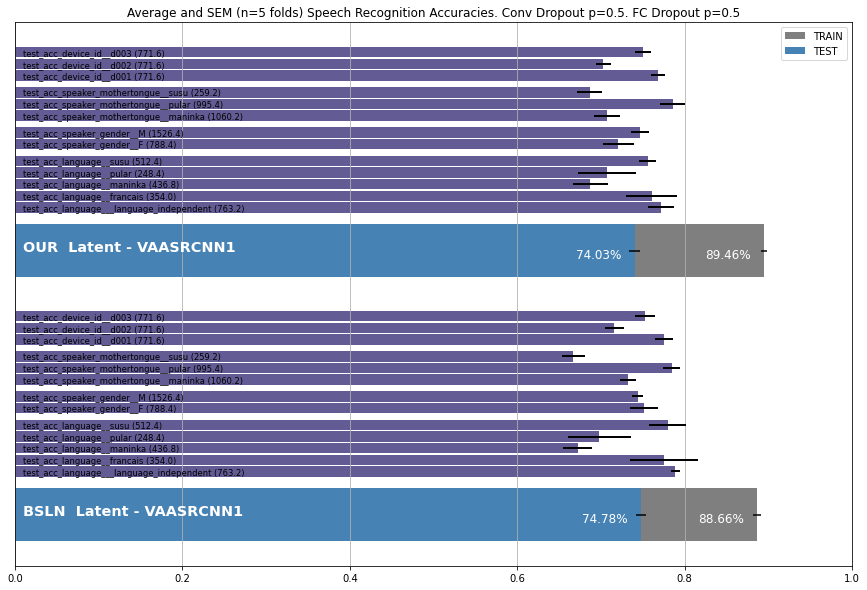

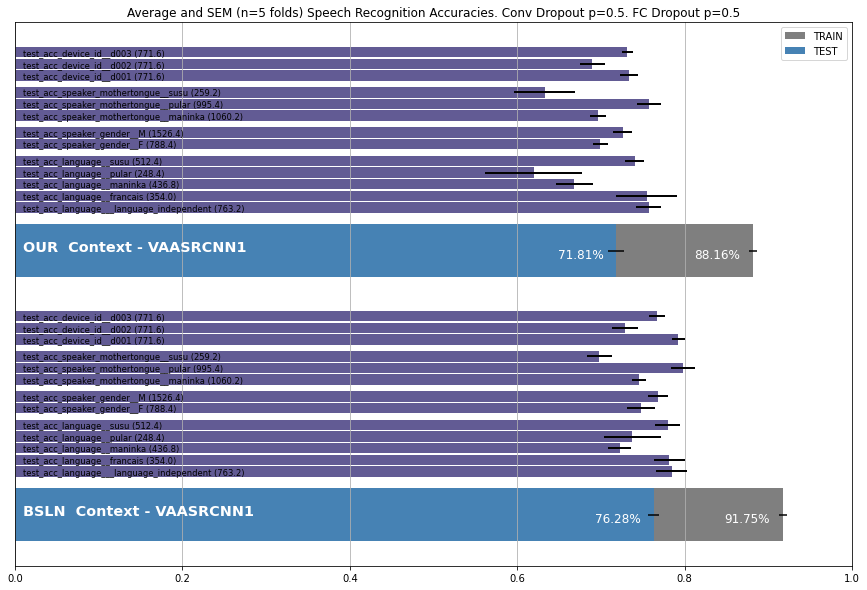

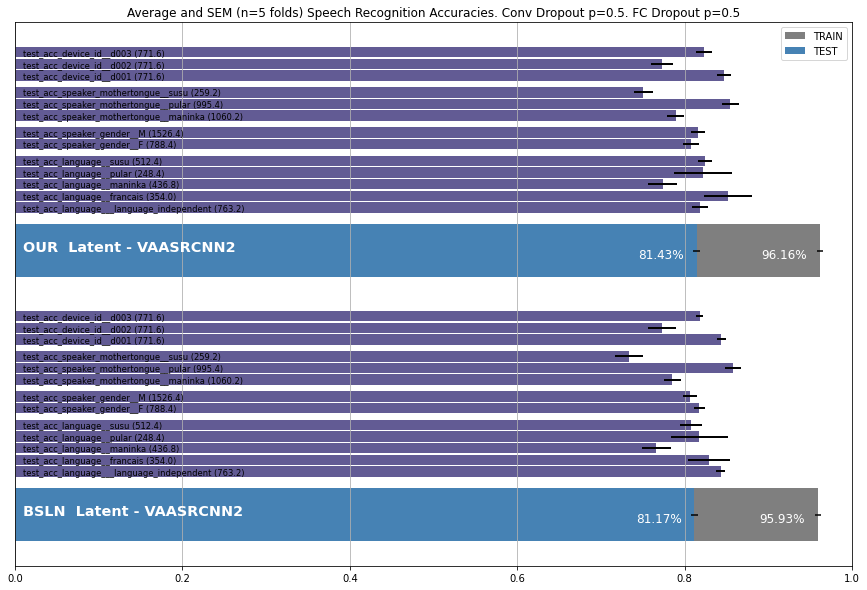

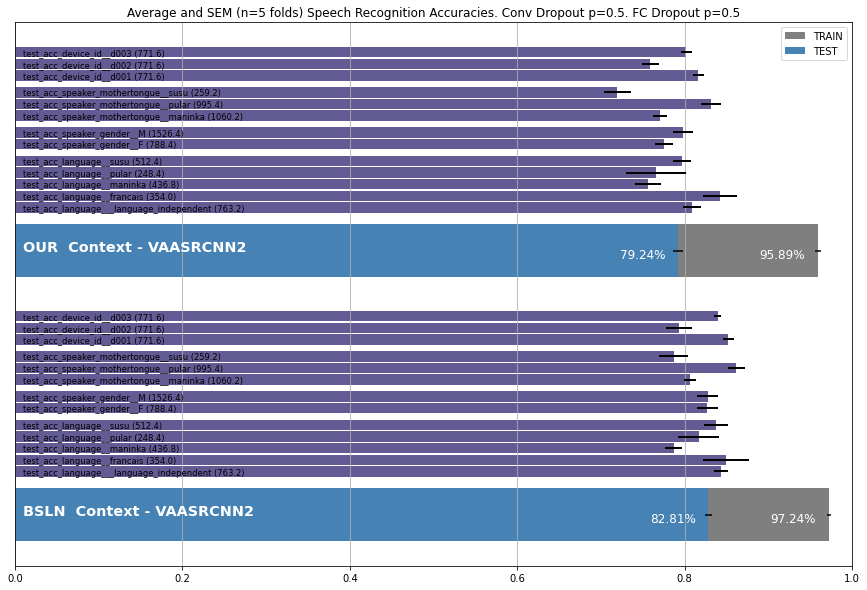

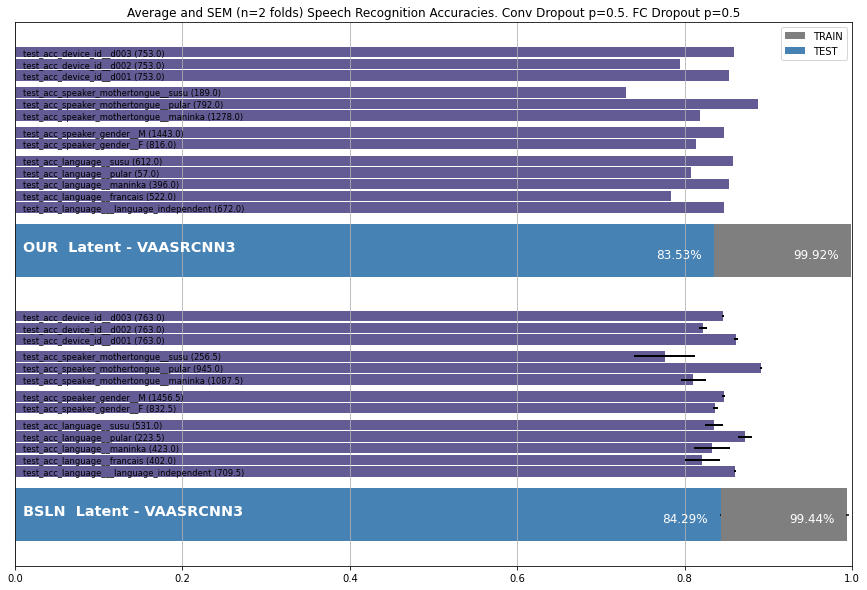

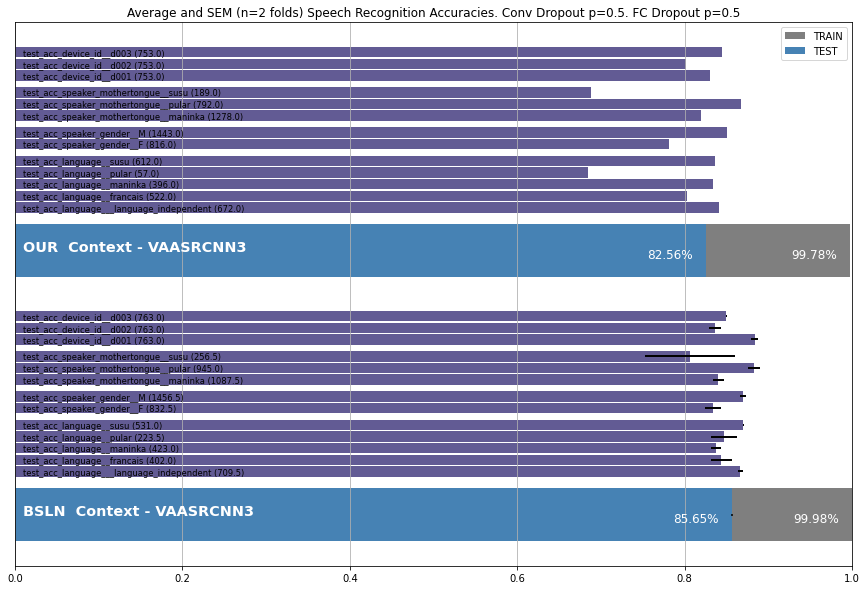

In [31]:
compared_features_latent = ['wav2vec_features-z', 'retrained-wav2vec_features-z']
compared_features_ctx = ['wav2vec_features-c', 'retrained-wav2vec_features-c']

for model_name in model_names:
    plot_summary_results([model_name], plotted_variables, compared_features_latent)
    plot_summary_results([model_name], plotted_variables, compared_features_ctx)
